In [1]:
import asyncio
import datetime as dt
import math
from typing import Literal

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

In [2]:
pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [3]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [4]:
from fetching_from_local_db.enums import AssetClass, Index, StrikeSpread
from fetching_from_local_db.fetch_from_db import _fetch_batch, fetch_data, fetch_spot_data

In [5]:
from expiries import dict_expiries

In [6]:
def resample(
    data: pl.DataFrame, timeframe, offset: dt.timedelta | None = None
) -> pl.DataFrame:
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(
            [
                pl.col("o").first().alias("o"),
                pl.col("h").max().alias("h"),
                pl.col("l").min().alias("l"),
                pl.col("c").last().alias("c"),
                # pl.col("volume").sum().alias("volume"),
            ]
        )
    )


# ohlc_resampled = resample(pl.DataFrame(bnf_1min), '7d', pd.Timedelta(days=4))
# ohlc_resampled

In [7]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2019, 2026),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe

    # Iterate over each year
    for year in range(2019, 2026):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()

        # Calculate total number of trades
        total_trades = len(year_trades)

        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100

        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()

        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f"{variation}"

        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]

    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0][
        "ROI%"
    ].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum()
        - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio: stats_df8}

In [8]:
bnf_1min = pd.read_csv("../data/nifty_min.csv")

In [9]:
bnf_1min.columns = ['index', 'datetime', 'o', 'h', 'l', 'c', 'v']
# bnf_1min.tail()

In [10]:
bnf_1min["datetime"] = pd.to_datetime(bnf_1min["datetime"]).dt.tz_localize(None)
# bnf_1min = bnf_1min[((bnf_1min['datetime'].dt.year == 2020) & (bnf_1min['datetime'].dt.month == 4))]
bnf_1min = bnf_1min[
    (bnf_1min["datetime"].dt.year >= 2019) & (bnf_1min["datetime"].dt.year <= 2025)
]

In [11]:
# dict_expiries

In [12]:
from datetime import date
from bisect import bisect_left

def get_next_expiry(input_date, index_symbol):
    expiries = dict_expiries.get(index_symbol)
    if not expiries:
        return None
        
    expiry_dates = sorted({dt.date() for dt in expiries})
    pos = bisect_left(expiry_dates, input_date)
    return expiry_dates[pos] if pos < len(expiry_dates) else None


In [13]:
index_ = 'nifty'

if index_ == 'nifty':
    LOT_SIZE_ = 75
    STRIKE_SPREAD_ = 50
    INDEX_LEVERAGE_ = 8
    PORTFOLIO_ = 1_00_00_000

In [14]:
import pandas as pd

async def add_atr(df, period=14):
    """
    Adds an 'ATR' column to the DataFrame using Wilder's smoothing (like TradingView).
    
    Parameters:
    df (pd.DataFrame): Must contain 'h', 'l', 'c' columns for high, low, close
    period (int): ATR period (default 14)
    
    Returns:
    pd.DataFrame: With 'ATR' column added
    """
    high = df['h']
    low = df['l']
    close = df['c']

    # True Range
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR with Wilder's smoothing (like an EMA with alpha=1/period)
    atr = tr.ewm(alpha=1/period, adjust=False).mean()

    df['ATR'] = atr
    return df


In [15]:
async def send_trade(entry_timestamp, direction, atr, tradebook, trade_num, spot_level):
    if direction == 1:
        # opt_type = 'P'
        side = 'LONG'
    elif direction == -1:
        # opt_type = "C"
        side = 'SHORT'
    else:
        return tradebook

    current_date = entry_timestamp.date()
    current_time = entry_timestamp.time()

    trade = {
        'date': current_date,
        'Morning ATR': atr,
        'side': side,
        'entry_time': entry_timestamp,
        'trade_num': trade_num,
        'entry price': spot_level,
    }
        
    tradebook.append(trade)
    return tradebook

async def take_exit(exit_timestamp, direction, tradebook, trade_num, spot_level, remark):

    current_date = exit_timestamp.date()
    current_time = exit_timestamp.time()

    if direction == 1:
        # opt_type = 'P'
        side = 'LONG'
    elif direction == -1:
        # opt_type = "C"
        side = 'SHORT'
    else:
        return tradebook

    for trade in tradebook:
        if (
            trade['side'] == side and
            trade['date'] == current_date and
            'exit_time' not in trade
        ):
                trade['exit price'] = spot_level
                trade['exit_time'] = exit_timestamp
                trade['exit price'] = spot_level
                trade['remarks'] = remark
                # trade['high level at exit'] = high_level
                # trade['low level at exit'] = low_level
                trade['points'] = (trade['exit price'] - trade['entry price']) if side == 'LONG' else (trade['entry price'] - trade['exit price']) 
           
    return tradebook

In [16]:
async def backtest_intraday_levels2(df, multiplier, tf, offset):
    df['datetime'] = pd.to_datetime(df['datetime'])
    # df = df[df['datetime'].dt.year >= 2025]
    df['date'] = df['datetime'].dt.date
    # print(df.head().to_string())
    
    tradebook = []

    eod_time = dt.time(15, 20)
    no_more_trade_time = dt.time(15, 0)
    allowed_dte = [0, 1, 2, 3, 6]

    for date, group in df.groupby('date'):
        current_date = date
        group = group.reset_index(drop=True)
        # print(date)
        # Get 9:15 candle
        morning_candle = group[group['datetime'].dt.time == pd.to_datetime("09:15").time()]
        if morning_candle.empty:
            continue

        morning_atr = morning_candle.iloc[0]['ATR']
        running_high = group.iloc[0]['h'] # Initialising
        running_low = group.iloc[0]['l'] # Initialising

        is_high_breached = False
        is_low_breached = False

        in_trade_long = False
        in_trade_short = False

        data_fetched_pe = False
        data_fetched_ce = False

        trade_num = 1
        max_trades = 25

        for i in range(0, len(group)):
            row = group.iloc[i]
            previous_row = group.iloc[i-1]
            running_high = max(running_high, row['h'])
            running_low = min(running_low, row['l'])
            
            current_datetime = row['datetime']
            
            high_level = running_low + (multiplier * morning_atr)
            low_level = running_high - (multiplier * morning_atr)
            
            long_tsl = low_level
            short_tsl = high_level
            
            # print(row)
            # print(group.iloc[i]['datetime'], high_level, low_level, row['c'])
            # print(f'RH : {running_high} , RL : {running_low}')

            # high_strike = int(round(high_level / STRIKE_SPREAD_) * STRIKE_SPREAD_)
            # low_strike = int(round(low_level / STRIKE_SPREAD_) * STRIKE_SPREAD_)

            expiry = get_next_expiry(date, index_)
            dte = (expiry - current_date).days            

            if not in_trade_long and not in_trade_short and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                if row['c'] >= high_level and trade_num <= max_trades:
                    tradebook = await send_trade(current_datetime, 1, morning_atr, tradebook, trade_num, row['c'])
                    trade_num += 1
                    # is_high_breached = True
                    in_trade_long = True
                    long_tsl = low_level

            if in_trade_long:
                if row['c'] <= long_tsl:
                    # TSL Hit
                    tradebook = await take_exit(current_datetime, 1, tradebook, trade_num, row['c'], 'TSL')
                    in_trade_long = False
                    # is_high_breached = False

                    # Send Short Trade
                    running_low = row['l']
                    # print(f'Running Low changed to {running_low}')
                    high_level = running_low + (multiplier * morning_atr)
                    # print(f'High Level changed to {high_level}')
                    if trade_num <= max_trades and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                        tradebook = await send_trade(current_datetime, -1, morning_atr, tradebook, trade_num, row['c'])
                        trade_num += 1
                        long_tsl = float('inf')
                        short_tsl = high_level
                        in_trade_short = True
                        # is_low_breached = True
                    else:
                        continue
                    
                elif current_datetime.time() >= eod_time:
                    # EOD Exit
                    tradebook = await take_exit(current_datetime, 1, tradebook, trade_num, row['c'], 'EOD')
                    in_trade_long = False
                    # is_high_breached = False
                    long_tsl = float('inf')

            if not in_trade_short and not in_trade_long and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                if row['c'] <= low_level and trade_num <= max_trades:
                    tradebook = await send_trade(current_datetime, -1, morning_atr, tradebook, trade_num, row['c'])
                    trade_num += 1
                    
                    # is_low_breached = True
                    in_trade_short = True

            if in_trade_short:
                if row['c'] >= short_tsl:
                    # TSL Hit
                    tradebook = await take_exit(current_datetime, -1, tradebook, trade_num, row['c'], 'TSL')
                    
                    in_trade_short = False
                    # is_low_breached = False

                    # Send Long Trade
                    running_high = row['h']
                    # print(f'Running High changed to {running_high}')
                    low_level = running_high - (multiplier * morning_atr)
                    # print(f'Low Level changed to {low_level}')
                    if trade_num <= max_trades and current_datetime.time() <= no_more_trade_time and dte in allowed_dte:
                        tradebook = await send_trade(current_datetime, 1, morning_atr, tradebook, trade_num, row['c'])
                        trade_num += 1
                        short_tsl = float('-inf')
                        long_tsl = low_level
                        in_trade_long = True
                        # is_high_breached = True
                    else:
                        continue

                elif current_datetime.time() >= eod_time:
                    # EOD Exit
                    tradebook = await take_exit(current_datetime, -1, tradebook, trade_num, row['c'], 'EOD')

                    in_trade_short = False
                    # is_low_breached = False
                    short_tsl = float('-inf')

    tb = pd.DataFrame(tradebook)
    if len(tb) > 0:
        tb['index_lev'] = 8  # default for all
    
        tb['exit_time'] = pd.to_datetime(tb['exit_time'])
        tb['slippage'] = 0.0002 * (tb['entry price'] + tb['exit price'])
        tb['final_points'] = tb['points'] - tb['slippage']
        tb['portfolio'] = PORTFOLIO_
        tb['qty'] = np.where(tb['side'] == 'LONG', tb['portfolio'] * tb['index_lev'] / tb['entry price'], (tb['portfolio'] * tb['index_lev'] / tb['entry price']))
        tb['pnl'] = tb['final_points'] * tb['qty']
        tb['ROI%'] = tb['pnl'] * 100 / tb['portfolio']
        tb['Trade Year'] = tb['exit_time'].dt.year

    return tb

In [17]:
TF_ = '10m'
OFFSET_ = '5m'
ATR_WINDOW_ = 14
MULTIPLIER_ = 2
bnf_df = resample(pl.DataFrame(bnf_1min), TF_, OFFSET_)
bnf_df_pandas = bnf_df.to_pandas()
bnf_df_pandas = await add_atr(bnf_df_pandas, ATR_WINDOW_)
tb = await backtest_intraday_levels2(bnf_df_pandas, MULTIPLIER_, TF_, OFFSET_)
# tb

In [18]:
# if len(tb) > 0:
#     tb['index_lev'] = 8  # default for all

#     tb['exit_time'] = pd.to_datetime(tb['exit_time'])
#     tb['slippage'] = 0.0002 * (tb['entry price'] + tb['exit price'])
#     tb['final_points'] = tb['points'] - tb['slippage']
#     tb['portfolio'] = PORTFOLIO_
#     tb['qty'] = np.where(tb['side'] == 'LONG', tb['portfolio'] * tb['index_lev'] / tb['entry price'], (tb['portfolio'] * tb['index_lev'] / tb['entry price']))
#     tb['pnl'] = tb['final_points'] * tb['qty']
#     tb['ROI%'] = tb['pnl'] * 100 / tb['portfolio']
#     tb['Trade Year'] = tb['exit_time'].dt.year

In [19]:
# tb_may = tb[-61:]
# tb[tb['Trade Year'] >= 2025].tail(65)
tb.tail(100)

,date,Morning ATR,side,entry_time,trade_num,entry price,exit price,exit_time,remarks,points,index_lev,slippage,final_points,portfolio,qty,pnl,ROI%,Trade Year
3842,2025-04-02,36.8143,SHORT,2025-04-02 09:45:00,3,23203.0000,23268.9000,2025-04-02 10:25:00,TSL,-65.9000,8,9.2944,-75.1944,10000000,3447.8300,-259257.4408,-2.5926,2025.0000
3843,2025-04-02,36.8143,LONG,2025-04-02 10:25:00,4,23268.9000,23330.8000,2025-04-02 15:25:00,EOD,61.9000,8,9.3199,52.5801,10000000,3438.0654,180773.6850,1.8077,2025.0000
3844,2025-04-03,38.4467,LONG,2025-04-03 09:15:00,1,23240.9000,23241.6000,2025-04-03 15:25:00,EOD,0.7000,8,9.2965,-8.5965,10000000,3442.2075,-29590.9367,-0.2959,2025.0000
3845,2025-04-07,111.7856,LONG,2025-04-07 09:15:00,1,22030.8000,21918.1500,2025-04-07 10:05:00,TSL,-112.6500,8,8.7898,-121.4398,10000000,3631.2798,-440981.8618,-4.4098,2025.0000
3846,2025-04-07,111.7856,SHORT,2025-04-07 10:05:00,2,21918.1500,22044.6500,2025-04-07 14:25:00,TSL,-126.5000,8,8.7926,-135.2926,10000000,3649.9431,-493810.1436,-4.9381,2025.0000
3847,2025-04-07,111.7856,LONG,2025-04-07 14:25:00,3,22044.6500,22238.0000,2025-04-07 15:25:00,EOD,193.3500,8,8.8565,184.4935,10000000,3628.9984,669526.5110,6.6953,2025.0000
3848,2025-04-08,91.1352,SHORT,2025-04-08 09:55:00,1,22390.2500,22552.3000,2025-04-08 12:05:00,TSL,-162.0500,8,8.9885,-171.0385,10000000,3572.9838,-611117.8214,-6.1112,2025.0000
3849,2025-04-08,91.1352,LONG,2025-04-08 12:05:00,2,22552.3000,22487.0500,2025-04-08 13:45:00,TSL,-65.2500,8,9.0079,-74.2579,10000000,3547.3100,-263415.6871,-2.6342,2025.0000
3850,2025-04-08,91.1352,SHORT,2025-04-08 13:45:00,3,22487.0500,22650.9500,2025-04-08 14:15:00,TSL,-163.9000,8,9.0276,-172.9276,10000000,3557.6032,-615207.7751,-6.1521,2025.0000
3851,2025-04-08,91.1352,LONG,2025-04-08 14:15:00,4,22650.9500,22547.2000,2025-04-08 15:25:00,EOD,-103.7500,8,9.0396,-112.7896,10000000,3531.8607,-398357.2610,-3.9836,2025.0000


In [20]:
# tb_may.to_csv('scalper_may.csv', index=False)

In [21]:
tb['ROI%'].sum()

-229.0158011959518

In [22]:
stats = generate_stats(tb, 'ATR Dynamic')
for x, y in stats.items():
    z = pd.DataFrame(y)
    break

z

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2019,-22.3073,541,37.3383,3.3345,-2.0528,-76.7260,-0.2907,ATR Dynamic
2020,49.7804,608,43.2566,4.7003,-3.4388,-105.6502,0.4712,ATR Dynamic
2021,-131.2941,632,38.1329,3.1080,-2.2515,-171.8164,-0.7642,ATR Dynamic
2022,51.5915,579,43.1779,3.2034,-2.2774,-62.1215,0.8305,ATR Dynamic
2023,-99.9747,620,36.4516,2.2387,-1.5378,-140.4024,-0.7121,ATR Dynamic
2024,-43.8629,677,36.3368,2.9449,-1.7826,-98.3161,-0.4461,ATR Dynamic
2025,-32.9486,284,40.8451,2.5714,-1.9716,-67.2658,-0.4898,ATR Dynamic
Overall,-229.0158,3941,39.1679,3.2308,-2.1766,-343.9690,-0.6658,ATR Dynamic


In [130]:
stats = generate_stats(tb, 'ATR Dynamic')
for x, y in stats.items():
    z = pd.DataFrame(y)
    break

z

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2019,109.1563,522,50.9579,1.1667,-0.7859,-8.7944,12.4121,ATR Dynamic
2020,274.3075,589,54.4992,1.9992,-1.3710,-18.9987,14.4382,ATR Dynamic
2021,106.0451,612,50.4902,1.2715,-0.9467,-21.0988,5.0261,ATR Dynamic
2022,139.7454,556,53.5971,1.3295,-0.9940,-17.1861,8.1313,ATR Dynamic
2023,36.7819,601,48.2529,0.8606,-0.6842,-12.7855,2.8768,ATR Dynamic
2024,76.7475,677,48.1536,1.0651,-0.7706,-22.2215,3.4537,ATR Dynamic
2025,30.2279,180,58.8889,0.8815,-0.8542,-8.3276,3.6298,ATR Dynamic
Overall,773.0116,3737,50.9033,1.2690,-0.9107,-22.2215,34.7866,ATR Dynamic


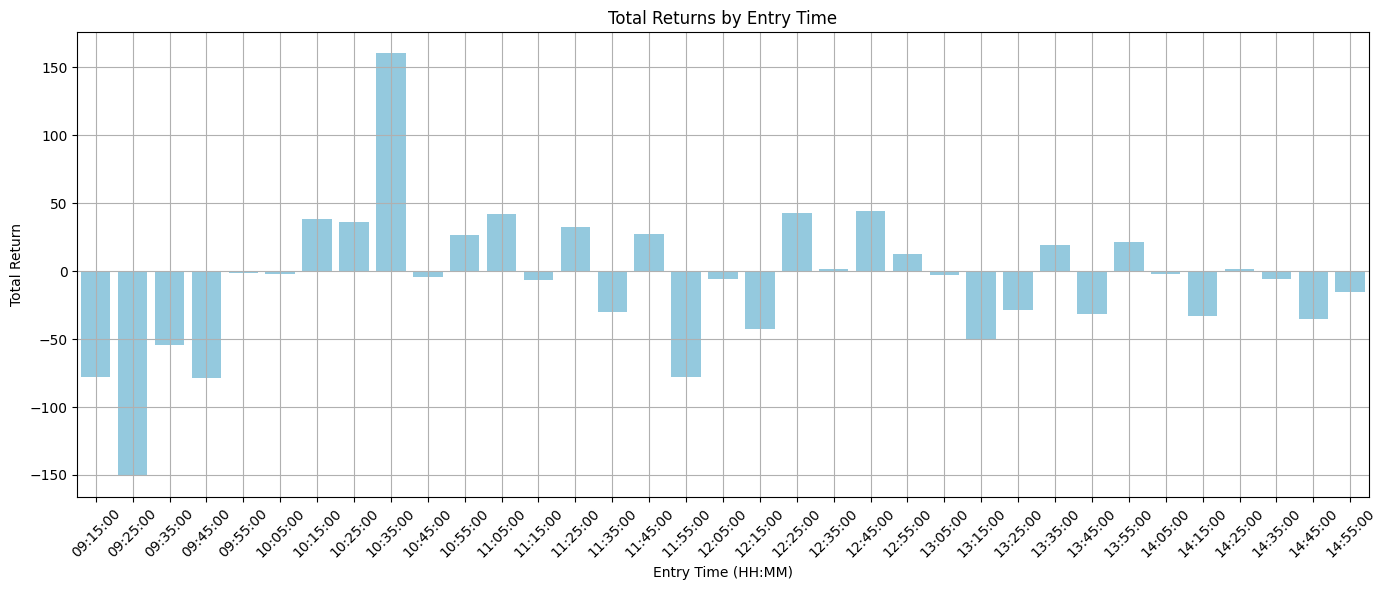

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = tb.copy()  # your DataFrame

# Step 1: Convert time to string format (HH:MM) for better x-axis display
df['entry_time_str'] = df['entry_time'].apply(lambda t: t.strftime('%H:%M:%S'))

# Step 2: Group by time and sum the returns
agg_df = df.groupby('entry_time_str')['ROI%'].sum().reset_index()

# Step 3: Plot the summed returns by time
plt.figure(figsize=(14, 6))
sns.barplot(x='entry_time_str', y='ROI%', data=agg_df, color='skyblue')
plt.xticks(rotation=45)
plt.title('Total Returns by Entry Time')
plt.xlabel('Entry Time (HH:MM)')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
# tb.to_csv('ATR_Dynamic_JJMS_10m_14_2.csv', index=False)

In [68]:
# tb = tb_with_hedge
tb['Cumulative ROI%'] = tb['ROI%'].cumsum()
tb['Max Cumulative ROI%'] = tb['Cumulative ROI%'].cummax()  # Maximum value so far
tb['DD'] = tb['Cumulative ROI%'] - tb['Max Cumulative ROI%']  # Drawdown
tb.tail()

,date,Morning ATR,side,entry_time,trade_num,entry price,exit price,exit_time,remarks,points,index_lev,slippage,final_points,portfolio,qty,pnl,ROI%,Trade Year,Cumulative ROI%,Max Cumulative ROI%,DD
3937,2025-05-27,39.5950,SHORT,2025-05-27 11:35:00,5,24968.9500,24786.1500,2025-05-27 14:45:00,TSL,182.8000,8,9.9510,172.8490,10000000,3203.9793,553804.5613,5.5380,2025.0000,-234.9537,91.4590,-326.4127
3938,2025-05-27,39.5950,LONG,2025-05-27 14:45:00,6,24786.1500,24837.7000,2025-05-27 15:25:00,EOD,51.5500,8,9.9248,41.6252,10000000,3227.6090,134349.9656,1.3435,2025.0000,-233.6102,91.4590,-325.0692
3939,2025-05-28,49.4349,SHORT,2025-05-28 09:55:00,1,24763.9000,24757.1500,2025-05-28 15:25:00,EOD,6.7500,8,9.9042,-3.1542,10000000,3230.5089,-10189.7036,-0.1019,2025.0000,-233.7121,91.4590,-325.1711
3940,2025-05-29,30.3131,SHORT,2025-05-29 09:15:00,1,24803.6000,24759.6000,2025-05-29 12:55:00,TSL,44.0000,8,9.9126,34.0874,10000000,3225.3383,109943.2663,1.0994,2025.0000,-232.6127,91.4590,-324.0717
3941,2025-05-29,30.3131,LONG,2025-05-29 12:55:00,2,24759.6000,24880.8500,2025-05-29 15:25:00,EOD,121.2500,8,9.9281,111.3219,10000000,3231.0700,359688.8803,3.5969,2025.0000,-229.0158,91.4590,-320.4748


In [69]:
import pandas as pd

def calculate_dte_stats(df):
    # Check required columns
    # print(df.columns)
    if 'dte' not in df.columns or 'ROI%' not in df.columns or 'DD' not in df.columns or 'type' not in df.columns:
        raise ValueError("DataFrame must contain 'dte', 'ROI%', 'DD', and 'type' columns.")
    
    # Add win flag
    df['is_win'] = df['ROI%'] > 0

    # Group by both DTE and Option Type
    grouped_stats = df.groupby(['dte', 'type']).agg(
        returns_sum=('ROI%', 'sum'),
        max_drawdown=('DD', 'min'),
        total_trades=('dte', 'count'),
        wins=('is_win', 'sum')
    ).reset_index()

    # Calculate ratio of returns sum to max drawdown
    grouped_stats['returns_to_max_dd_ratio'] = (
        grouped_stats['returns_sum'] / grouped_stats['max_drawdown'].abs()
    )

    # Calculate win rate
    grouped_stats['win_rate'] = (grouped_stats['wins'] / grouped_stats['total_trades']) * 100

    return grouped_stats


In [70]:
import pandas as pd

def calculate_opt_type_stats(df):

    # print(df.columns)
    if 'side' not in df.columns or 'ROI%' not in df.columns or 'DD' not in df.columns:
        raise ValueError("DataFrame must contain 'DTE', 'returns', and 'drawdown' columns.")
    
    # Group by DTE and calculate required stats
    grouped_stats = df.groupby('side').agg(
        returns_sum=('ROI%', 'sum'),
        max_drawdown=('DD', 'min'),  # Assuming 'drawdown' contains negative values
        total_trades=('side', 'count')
    ).reset_index()
    
    # Calculate ratio of returns sum to max drawdown
    grouped_stats['returns_to_max_dd_ratio'] = (
        grouped_stats['returns_sum'] / grouped_stats['max_drawdown'].abs()
    )

    return grouped_stats


In [71]:
import pandas as pd

def calculate_trade_num_stats(df):

    # print(df.columns)
    if 'trade_num' not in df.columns or 'ROI%' not in df.columns or 'DD' not in df.columns:
        raise ValueError("DataFrame must contain 'DTE', 'returns', and 'drawdown' columns.")
    
    # Group by DTE and calculate required stats
    grouped_stats = df.groupby('trade_num').agg(
        returns_sum=('ROI%', 'sum'),
        max_drawdown=('DD', 'min'),  # Assuming 'drawdown' contains negative values
        total_trades=('trade_num', 'count')
    ).reset_index()
    
    # Calculate ratio of returns sum to max drawdown
    grouped_stats['returns_to_max_dd_ratio'] = (
        grouped_stats['returns_sum'] / grouped_stats['max_drawdown'].abs()
    )

    return grouped_stats


In [72]:
stats_opt_type = calculate_opt_type_stats(tb)
stats_opt_type

,side,returns_sum,max_drawdown,total_trades,returns_to_max_dd_ratio
0,LONG,-110.9494,-343.9690,2027,-0.3226
1,SHORT,-118.0664,-342.6598,1915,-0.3446


In [73]:
stats_trade_num = calculate_trade_num_stats(tb)
stats_trade_num

,trade_num,returns_sum,max_drawdown,total_trades,returns_to_max_dd_ratio
0,1,-140.1312,-342.5022,1525,-0.4091
1,2,-111.6173,-342.6598,1128,-0.3257
2,3,43.6456,-341.3662,701,0.1279
3,4,-47.7950,-338.4297,345,-0.1412
4,5,41.6354,-341.0927,137,0.1221
5,6,-10.1121,-343.9690,62,-0.0294
6,7,2.5438,-340.2732,26,0.0075
7,8,0.7168,-303.9777,11,0.0024
8,9,-5.4347,-305.1266,3,-0.0178
9,10,-5.9264,-308.4444,3,-0.0192


In [21]:
# SIMULATION

TF_ = ['5m', '3m', '10m', '15m']
ATR_WINDOW_ = [6, 9, 12, 15, 18]
MULTIPLIER_ = [1.5, 2, 2.5, 3, 3.5, 4, 5]

for i in TF_:
    for j in ATR_WINDOW_:
        for k in MULTIPLIER_:
            if i == '10m':
                z = '5m'
            else:
                z = '0m'
            variation = f'TF: {i}, ATR: {j}, MULT: {k}'
            print(variation)
            bnf_df = resample(pl.DataFrame(bnf_1min), i, z)
            bnf_df_pandas = bnf_df.to_pandas()
            bnf_df_pandas = await add_atr(bnf_df_pandas, j)
            tb = await backtest_intraday_levels2(bnf_df_pandas, k, i, z)

            if len(tb) > 0:
                stats = generate_stats(tb, variation)
                for x, y in stats.items():
                    if x > -1:
                        q = pd.DataFrame(y)
                        print(q.to_string())


TF: 5m, ATR: 6, MULT: 1.5
         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                  Variation
2019     -141.9420         1032  34.5930                2.4377             -1.4995    -155.8236      -0.9109  TF: 5m, ATR: 6, MULT: 1.5
2020      -21.2359         1084  37.1771                3.9011             -2.3398    -197.1585      -0.1077  TF: 5m, ATR: 6, MULT: 1.5
2021     -280.1376         1179  35.3690                2.3544             -1.6561    -293.8517      -0.9533  TF: 5m, ATR: 6, MULT: 1.5
2022      -65.1658          995  39.3970                2.5441             -1.7619     -86.7714      -0.7510  TF: 5m, ATR: 6, MULT: 1.5
2023     -246.3552         1066  33.0206                1.8456             -1.2549    -252.2188      -0.9768  TF: 5m, ATR: 6, MULT: 1.5
2024     -384.3823         1324  31.4199                2.2523             -1.4552    -398.5438      -0.9645  TF: 5m, ATR: 6, MULT: 1.5
2025     -183.8627    

/tmp/ipykernel_146740/520387500.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


TF: 15m, ATR: 15, MULT: 1.5
         Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                    Variation
2019     -432.4198          404  22.7723                2.4035             -2.0947    -435.5966      -0.9927  TF: 15m, ATR: 15, MULT: 1.5
2020     -541.4700          407  24.8157                4.9164             -3.3922    -539.9173      -1.0029  TF: 15m, ATR: 15, MULT: 1.5
2021     -559.5652          463  23.1102                2.4409             -2.3055    -562.2728      -0.9952  TF: 15m, ATR: 15, MULT: 1.5
2022     -463.0301          407  25.0614                2.4633             -2.3419    -467.2066      -0.9911  TF: 15m, ATR: 15, MULT: 1.5
2023     -368.2552          436  20.1835                1.9607             -1.5540    -369.6032      -0.9964  TF: 15m, ATR: 15, MULT: 1.5
2024     -487.4696          521  24.9520                2.4049             -2.0463    -487.2401      -1.0005  TF: 15m, ATR: 15, MULT: 1.5
2025  